<a href="https://colab.research.google.com/github/NelsonSpencer/PeopleAnalytics/blob/master/Predicting_Employee_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Introduction

Employees are the single most important asset companies possess. This project uses a dataset from [Kaggle](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) to predict which employees are likely to leave a company.

## Import Libraries

In [2]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from google.colab import files

#Project specifc 
import missingno
import warnings
warnings.filterwarnings("ignore")

#Modeling Imports
## preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline 
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer 

##model tools and eval
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

##models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Data

In [3]:
uploaded = files.upload()

Saving Employee-Attrition.csv to Employee-Attrition.csv


In [0]:
raw_data = pd.read_csv('Employee-Attrition.csv')

## Functions

In [0]:
def time_series_plot(df):
    """Given dataframe, generate times series plot of numeric data by daily, monthly and yearly frequency"""
    print("\nTo check time series of numeric data  by daily, monthly and yearly frequency")
    if len(df.select_dtypes(include='datetime64').columns)>0:
        for col in df.select_dtypes(include='datetime64').columns:
            for p in ['D', 'M', 'Y']:
                if p=='D':
                    print("Plotting daily data")
                elif p=='M':
                    print("Plotting monthly data")
                else:
                    print("Plotting yearly data")
                for col_num in df.select_dtypes(include=np.number).columns:
                    __ = df.copy()
                    __ = __.set_index(col)
                    __T = __.resample(p).sum()
                    ax = __T[[col_num]].plot()
                    ax.set_ylim(bottom=0)
                    ax.get_yaxis().set_major_formatter(
                    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
                    plt.show()

                    
def numeric_eda(df, hue=None):
    """Given dataframe, generate EDA of numeric data"""
    print("\nTo check: \nDistribution of numeric data")
    display(df.describe().T)
    columns = df.select_dtypes(include=np.number).columns
    # figure = plt.figure(figsize=(20, 10))
    # figure.add_subplot(1, len(columns), 1)
    # for index, col in enumerate(columns):
    #     if index > 0:
    #         figure.add_subplot(1, len(columns), index + 1)
    #     sns.boxplot(y=col, data=df, boxprops={'facecolor': 'None'})
    # figure.tight_layout()
    # plt.show()
    
    # if len(df.select_dtypes(include='category').columns) > 0:
    #     for col_num in df.select_dtypes(include=np.number).columns:
    #         for col in df.select_dtypes(include='category').columns:
    #             fig = sns.catplot(x=col, y=col_num, kind='violin', data=df, height=5, aspect=2)
    #             fig.set_xticklabels(rotation=90)
    #             plt.show()
    
    # # Plot the pairwise joint distributions
    # print("\nTo check pairwise joint distribution of numeric data")
    # if hue==None:
    #     sns.pairplot(df.select_dtypes(include=np.number))
    # else:
    #     sns.pairplot(df.select_dtypes(include=np.number).join(df[[hue]]), hue=hue)
    # plt.show()


def top5(df):
    """Given dataframe, generate top 5 unique values for non-numeric data"""
    columns = df.select_dtypes(include=['object', 'category']).columns
    for col in columns:
        print("Top 5 unique values of " + col)
        print(df[col].value_counts().reset_index().rename(columns={"index": col, col: "Count"})[
              :min(5, len(df[col].value_counts()))])
        print(" ")
    
    
def categorical_eda(df, hue=None):
    """Given dataframe, generate EDA of categorical data"""
    print("\nTo check: \nUnique count of non-numeric data\n")
    print(df.select_dtypes(include=['object', 'category']).nunique())
    top5(df)
    # Plot count distribution of categorical data
    for col in df.select_dtypes(include='category').columns:
        fig = sns.catplot(x=col, kind="count", data=df, hue=hue)
        fig.set_xticklabels(rotation=90)
        plt.show()
    

def eda(df):
    """Given dataframe, generate exploratory data analysis"""
    # check that input is pandas dataframe
    if type(df) != pd.core.frame.DataFrame:
        raise TypeError("Only pandas dataframe is allowed as input")
        
    # replace field that's entirely space (or empty) with NaN
    df = df.replace(r'^\s*$', np.nan, regex=True)

    print("Preview of data:")
    display(df.head(3))

    print("\nTo check: \n (1) Total number of entries \n (2) Column types \n (3) Any null values\n")
    print(df.info())

    # generate preview of entries with null values
    if len(df[df.isnull().any(axis=1)] != 0):
        print("\nPreview of data with null values:")
        display(df[df.isnull().any(axis=1)].head(3))
        missingno.matrix(df)
        plt.show()

    # generate count statistics of duplicate entries
    if len(df[df.duplicated()]) > 0:
        print("\n***Number of duplicated entries: ", len(df[df.duplicated()]))
        display(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
    else:
        print("\nNo duplicated entries found")

    # EDA of categorical data
    categorical_eda(df)
    
    # EDA of numeric data
    numeric_eda(df)
        
    # Plot time series plot of numeric data
    # time_series_plot(df)

# Exploratory Data Analysis

## EDA Script

In [6]:
eda(raw_data)

Preview of data:


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0



To check: 
 (1) Total number of entries 
 (2) Column types 
 (3) Any null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 


,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.00,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0


EDA Takeaways



*   We can see that target variable (Attrition) is a binary variable so this will be a standard classification problem. It also looks to be very imbalanced. 
*   No Missing Values
*   A lot of attributes that will need to be scaled or encoded


## Descriptive Statistics

### Percentage of employees who Churned

In [54]:
# Total Number of Employees
n_employees = len(raw_data)

#The Number of employees who Stayed/Left
# print(raw_data.Attrition.value_counts())

#Percentage of employees who Stayed/Left
print(raw_data.Attrition.value_counts()/n_employees*100)

No     83.877551
Yes    16.122449
Name: Attrition, dtype: float64


### Correlation between Churned Employees and Features

In [0]:


#Get correlation of the entire DF with every column (can do this because every col is a number)
c = raw_data.corr()

#Clean up the correlation df with clear column names and show features just compared to the attrition target
s = c.unstack()
so = s.sort_values(kind="quicksort")


In [72]:
raw_data['Attrition']

0       Yes
1        No
2       Yes
3        No
4        No
       ... 
1465     No
1466     No
1467     No
1468     No
1469     No
Name: Attrition, Length: 1470, dtype: object

In [71]:
c

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,0.010661,-0.001686,0.208034,NaN,-0.010145,0.010146,0.024287,0.029820,0.509604,-0.004892,0.497855,0.028051,0.299635,0.003634,0.001904,0.053535,NaN,0.037510,0.680381,-0.019621,-0.021490,0.311309,0.212901,0.216513,0.202089
DailyRate,0.010661,1.000000,-0.004985,-0.016806,NaN,-0.050990,0.018355,0.023381,0.046135,0.002966,0.030571,0.007707,-0.032182,0.038153,0.022704,0.000473,0.007846,NaN,0.042143,0.014515,0.002453,-0.037848,-0.034055,0.009932,-0.033229,-0.026363
DistanceFromHome,-0.001686,-0.004985,1.000000,0.021042,NaN,0.032916,-0.016075,0.031131,0.008783,0.005303,-0.003669,-0.017014,0.027473,-0.029251,0.040235,0.027110,0.006557,NaN,0.044872,0.004628,-0.036942,-0.026556,0.009508,0.018845,0.010029,0.014406
Education,0.208034,-0.016806,0.021042,1.000000,NaN,0.042070,-0.027128,0.016775,0.042438,0.101589,-0.011296,0.094961,-0.026084,0.126317,-0.011111,-0.024539,-0.009118,NaN,0.018422,0.148280,-0.025100,0.009819,0.069114,0.060236,0.054254,0.069065
EmployeeCount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EmployeeNumber,-0.010145,-0.050990,0.032916,0.042070,NaN,1.000000,0.017621,0.035179,-0.006888,-0.018519,-0.046247,-0.014829,0.012648,-0.001251,-0.012944,-0.020359,-0.069861,NaN,0.062227,-0.014365,0.023603,0.010309,-0.011240,-0.008416,-0.009019,-0.009197
EnvironmentSatisfaction,0.010146,0.018355,-0.016075,-0.027128,NaN,0.017621,1.000000,-0.049857,-0.008278,0.001212,-0.006784,-0.006259,0.037600,0.012594,-0.031701,-0.029548,0.007665,NaN,0.003432,-0.002693,-0.019359,0.027627,0.001458,0.018007,0.016194,-0.004999
HourlyRate,0.024287,0.023381,0.031131,0.016775,NaN,0.035179,-0.049857,1.000000,0.042861,-0.027853,-0.071335,-0.015794,-0.015297,0.022157,-0.009062,-0.002172,0.001330,NaN,0.050263,-0.002334,-0.008548,-0.004607,-0.019582,-0.024106,-0.026716,-0.020123
JobInvolvement,0.029820,0.046135,0.008783,0.042438,NaN,-0.006888,-0.008278,0.042861,1.000000,-0.012630,-0.021476,-0.015271,-0.016322,0.015012,-0.017205,-0.029071,0.034297,NaN,0.021523,-0.005533,-0.015338,-0.014617,-0.021355,0.008717,-0.024184,0.025976
JobLevel,0.509604,0.002966,0.005303,0.101589,NaN,-0.018519,0.001212,-0.027853,-0.012630,1.000000,-0.001944,0.950300,0.039563,0.142501,-0.034730,-0.021222,0.021642,NaN,0.013984,0.782208,-0.018191,0.037818,0.534739,0.389447,0.353885,0.375281


In [70]:
so.filter(like='Attrition', axis=0)

Series([], dtype: float64)

In [69]:
so.to_frame()

0
NumCompaniesWorked      YearsAtCompany       -0.118421
YearsAtCompany          NumCompaniesWorked   -0.118421
YearsWithCurrManager    NumCompaniesWorked   -0.110319
NumCompaniesWorked      YearsWithCurrManager -0.110319
YearsInCurrentRole      NumCompaniesWorked   -0.090754
...                                                ...
                        StandardHours              NaN
YearsSinceLastPromotion EmployeeCount              NaN
                        StandardHours              NaN
YearsWithCurrManager    EmployeeCount              NaN
                        StandardHours              NaN

[676 rows x 1 columns]

In [0]:
so = so.filter(like='Attrition', axis=0).sort_values(ascending = False).to_frame().reset_index()


In [66]:
so

,level_0,level_1,0


In [0]:



so = so.rename(columns = {"level_0":'Attrition',"level_1":"Feature",0:"Correlation Coefficient"})
so = so[(so['Attrition']=='Attrition') & (so['Feature']!='Attrition')]

In [58]:
so

,Attrition,Feature,Correlation Coefficient


In [56]:
so.sort_values(by='Correlation Coefficient', ascending=False).head()

,Attrition,Feature,Correlation Coefficient


In [0]:
pd.set_option("display.max_columns", None)

Saving Employee-Attrition.csv to Employee-Attrition.csv


In [0]:
raw_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [0]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

# Data Preprocessing

### Preprocessing Steps


1.   Drop irrelevant columns
2.   Seperate independent and dependent variables
3.   Create transformers for variables to use in pipelines
4.   Create Pipelines
5.   Split data into training and test set

### Categorical Values

#### Ordinal vs Nominal

One thing we need to keep in mind with categorical variables is that there are two types, ordinal and nominal, and we encode them differently in the model.

- Ordinal variables have two or more categories which can be ranked or ordered
- Nominal variables have two or more categories which do not have an intrinsic order

Ordinal - These have already been changed to numerical values in the dataset, so we'll make sure to not pass them through the preprocessing so that we maintain the ordinal structure in the model.

Education
1.   Below College
2.   College
3.   Bachelor
4.   Master
5.   Doctor

EnvironmentSatisfaction
1. 'Low'
2. 'Medium'
3. 'High'
4. 'Very High'

JobInvolvement
1. 'Low'
2. 'Medium'
3. 'High'
4. 'Very High'

JobSatisfaction
1. 'Low'
2. 'Medium'
3. 'High'
4. 'Very High'

PerformanceRating
1. 'Low'
2. 'Good'
3. 'Excellent'
4. 'Outstanding'

RelationshipSatisfaction
1. 'Low'
2. 'Medium'
3. 'High'
4. 'Very High'

WorkLifeBalance
1. 'Bad'
2. 'Good'
3. 'Better'
4. 'Best'


In [0]:
# Dropping irrelevant columns 
df = raw_data.drop(['EmployeeCount','EmployeeNumber','Over18','StandardHours'],axis=1)

# Seperate dependent and independent variables
y = df['Attrition']
X = df.drop(['Attrition'],axis=1)

class_names = y.unique().tolist()

#Create transformers and pipeline that will be used before model fit
# define transformers
ss = StandardScaler() #standardize the feature scaling for the numerical features
ohe = OneHotEncoder(drop='first') #avoid dummy variable trap on categorical data
le = LabelEncoder() #turn into 0 and n number of classes

#Use correct Encoder based on if the targt variable
y = le.fit_transform(y)

#find numerical and categorical features 
ordinal_features = ['Education','EnvironmentSatisfaction','JobInvolvement',
                    'JobSatisfaction','PerformanceRating','RelationshipSatisfaction',
                    'WorkLifeBalance','JobLevel']
categorical_features = X.select_dtypes(include = 'object').columns.tolist()
n_features = X.select_dtypes(include = 'int').columns.tolist()
numeric_features = [item for item in n_features if item not in ordinal_features]

#create the preprocessing pipelines for both numeric and categorical data. no simple imputer as there's no missing data
numeric_transformer = Pipeline(steps=[
                      ('scaler', ss)])
categorical_transformer = Pipeline(steps=[
                      ('onehot', ohe)])

# create columntransformer preprocessor to be used in future models
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features), 
        ('cat', categorical_transformer, categorical_features)],remainder = 'passthrough')#keeps the ordinal values in the model without bein affected 

# split data into train and test 70% in train. stratify to make classes representative  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,stratify = y, random_state = 1)

#Modeling

### Decision Tree

In [0]:
# Import the classification algorithm
from sklearn.tree import DecisionTreeClassifier

# Initialize it and call model by specifying the random_state parameter
model = DecisionTreeClassifier(random_state = 42)

# Apply a decision tree model to fit features to the target
model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [0]:
# Check the accuracy score of the prediction for the training set
model.score(X_train,y_train) * 100

100.0

In [0]:
# Check the accuracy score of the prediction for the test set
model.score(X_test,y_test) * 100

80.97826086956522

#### Interpretation

In [0]:
from IPython.display import Image  
from sklearn import tree
import pydotplus

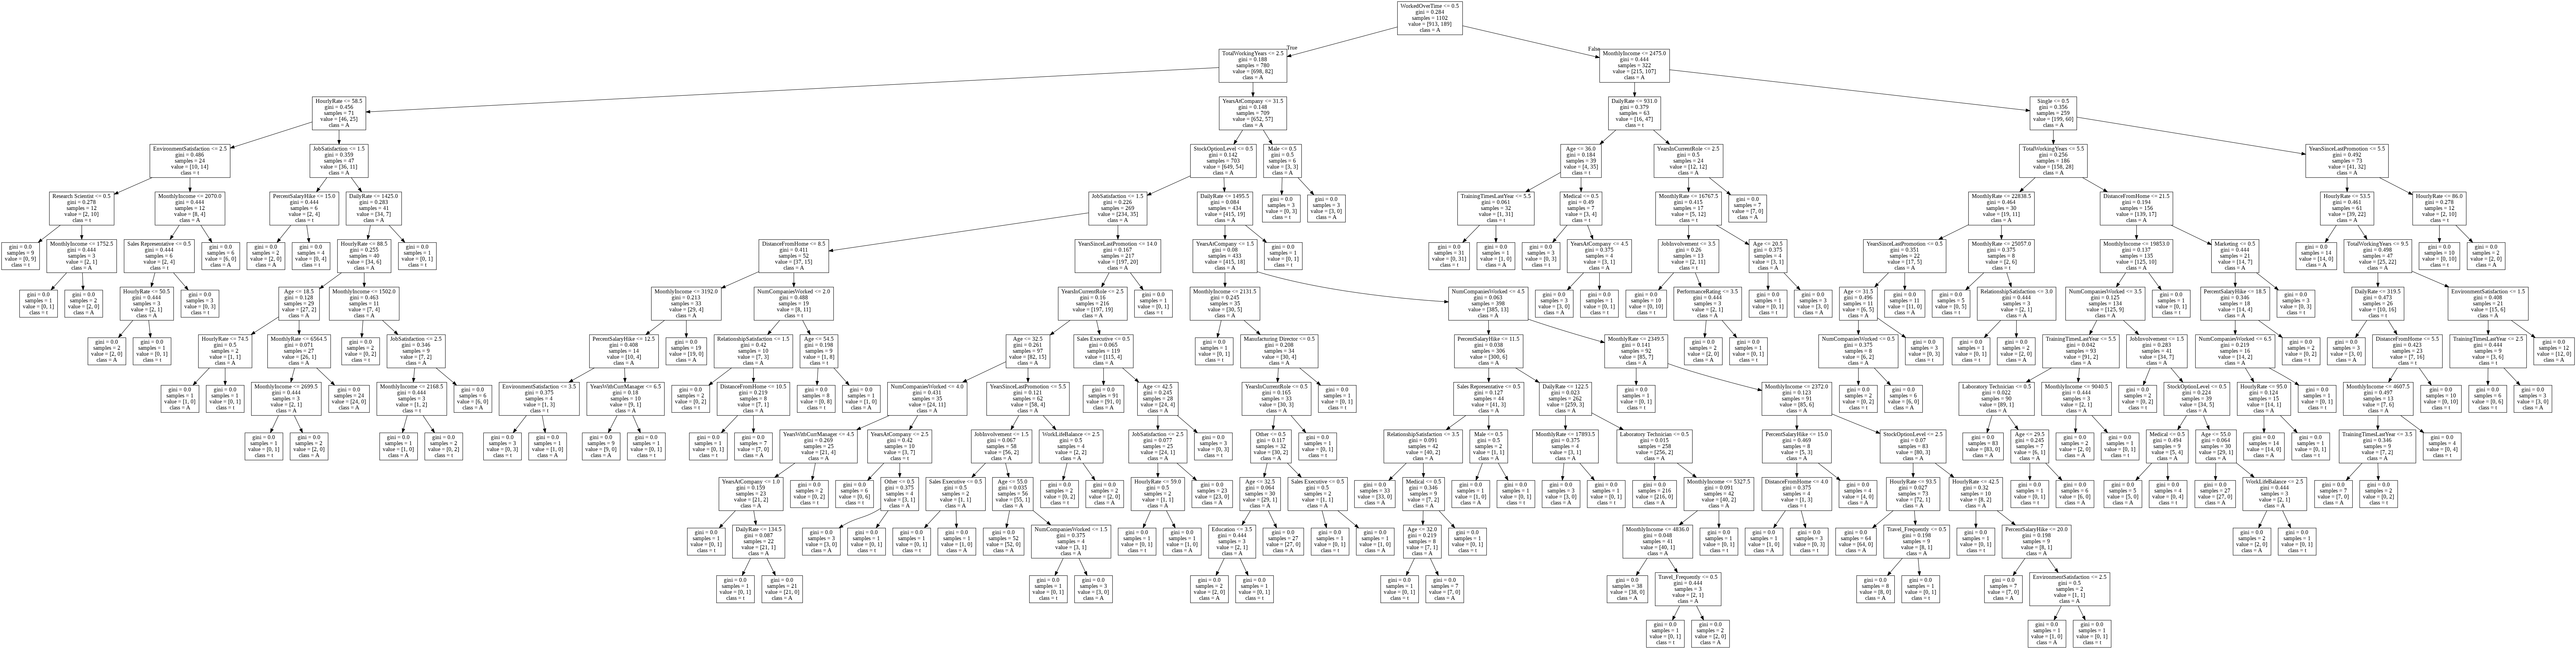

In [0]:
# Create DOT data
dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=X.columns,  
                                class_names='Attrition')

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

#### Overfitting

Overfitting is a common problem in modeling, especially for decision trees. Once the tree is fully grown (as the above image shows), it may provide highly accurate predictions for the training sample, yet fail to be that accurate on the test set. For that reason, the growth of the decision tree is usually controlled by:

*   “Pruning” the tree and setting a limit on the maximum depth it can have
*   Limiting the minimum number of observations in one leaf of the tree


In [0]:
# Initialize the DecisionTreeClassifier while limiting the depth of the tree to 5
model_depth_5 = DecisionTreeClassifier(max_depth = 5,random_state = 42)

# Apply a decision tree model to fit features to the target
model_depth_5.fit(X_train,y_train)

model_depth_5.score(X_train,y_train) * 100

89.83666061705989

In [0]:
# Initialize the DecisionTreeClassifier while limiting the sample size in leaves to 100
model_sample_100 = DecisionTreeClassifier(min_samples_leaf= 100,class_weight='balanced',random_state = 42)

# Apply a decision tree model to fit features to the target
model_sample_100.fit(X_train,y_train)

model_sample_100.score(X_train,y_train) * 100

61.796733212341195

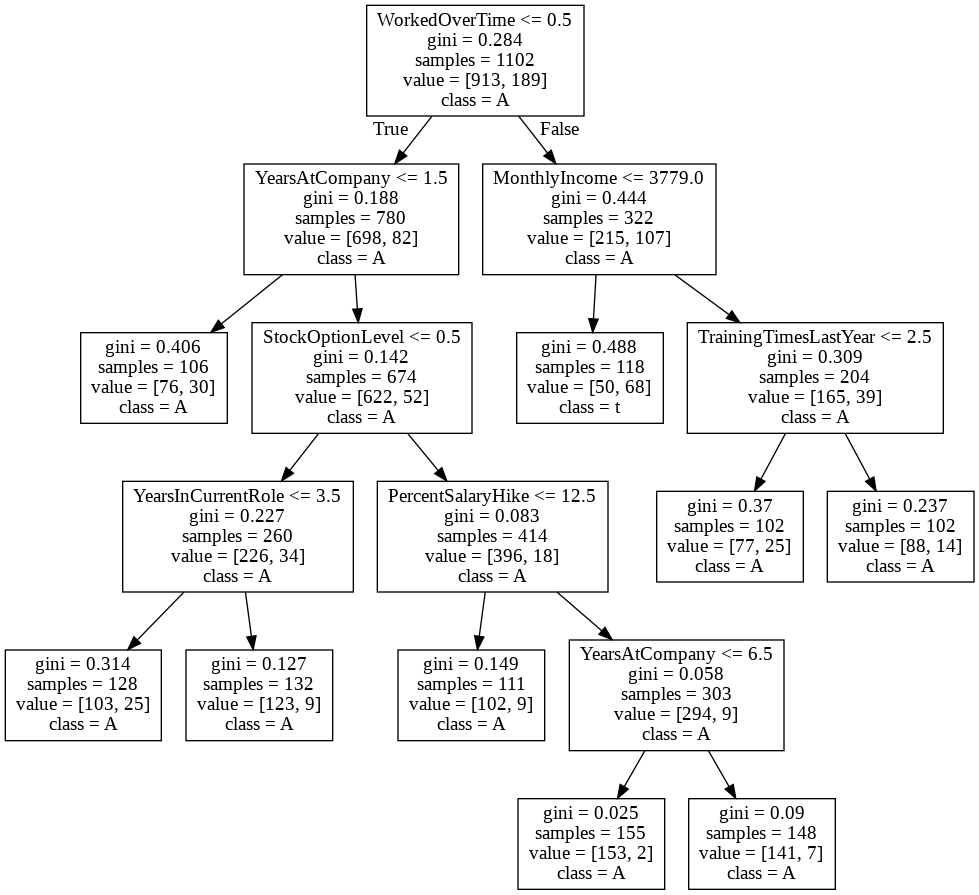

In [0]:
dot_data = tree.export_graphviz(model_sample_100, out_file=None, 
                                feature_names=X.columns,  
                                class_names='Attrition')

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

#### Evaluating Classification Models

In addition to just scoring the model by the accuracy. There are other ways to measure the model's success depending on the business problem or question at hand. Two other popular options are Precision and Recall. Before getting into those metrics, however, we need to first understand what's called a confusion matrix.



##### Confusion Matrix

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix. The confusion matrix shows the ways in which your classification model is confused when it makes predictions. It gives us insight not only into the errors being made by a classifier but more importantly the types of errors that are being made.

This is what they look like in practice:

![alt text](https://miro.medium.com/max/712/1*Z54JgbS4DUwWSknhDCvNTQ.png)



When the prediction is 0, we call it negative and when it is 1, we call it positive. In our dataset, leaving or churning is 1 and staying is 0.


---


TP = True Positive

**Interpretation:** 
We predicted positive and it’s true. We predicted an employee to leave (1) and in reality they did leave (1). 


---


TN = True Negative

**Interpretation:**
We predicted negative and it’s true. We predicted an employee to stay (0) and in reality they did stay (0).

---

FP = False Positive (also known as Type 1 Error)

**Interpretation:** 
We predicted positive and it was false.
We predicted an employee to leave (1), but in reality they stayed (0).

---
FN = False Negative: (also known as Type 2 Error)

**Interpretation:** 
You predicted negative and it’s false.
We predicted an employee to stay (0), but in reality they left (1).

##### Precision

Precision is calculated as the following:

![alt text](https://miro.medium.com/max/888/1*C3ctNdO0mde9fa1PFsCVqA.png)



If there are no False Positives, the precision score is equal to 1. If there are no True Positives, the recall score is equal to 0.

In [0]:
# Import the function to calculate precision score
from sklearn.metrics import precision_score

# Predict whether employees will churn using the test set
prediction = model_sample_100.predict(X_test)

# Calculate precision score by comparing target_test with the prediction
precision_score(y_test, prediction)

0.17391304347826086

##### Recall

Recall is calculated as the following:

![alt text](https://miro.medium.com/max/836/1*dXkDleGhA-jjZmZ1BlYKXg.png)

If there are no False Negatives, the recall score is equal to 1. If there are no True Positives, the recall score is equal to 0.

In [0]:
# Import the function to calculate recall score
from sklearn.metrics import recall_score

# Use the initial model to predict churn
prediction = model_sample_100.predict(X_test)

# Calculate recall score by comparing target_test with the prediction
recall_score(y_test, prediction)

0.6666666666666666

So how do we know which one is best to use? As mentioned above, it depends on the business objective.

If the goal of our model is to focus on those employees who are churning, than we would want to decrease False Negatives (employees that leave that weren't predicted to), which would mean Recall would be the option.

On the other hand, if we want to focus on those who stay, less False Positives (employees who stay but weren't predicted to) is the goal which would mean focusing on Precision.

##### ROC and AUC Score

While the Recall score is an important metric for measuring the accuracy of a classification algorithm, it puts too much weight on the number of False Negatives. On the other hand, Precision is concentrated on the number of False Positives.

The combination of those two results in the ROC curve allows us to measure both recall and precision. The area under the ROC curve is calculated as the AUC score.

In [0]:
# Import the function to calculate ROC/AUC score
from sklearn.metrics import roc_auc_score

# Use initial model to predict churn (based on features_test)
prediction = model_sample_100.predict(X_test)

# Calculate ROC/AUC score by comparing target_test with the prediction
roc_auc_score(y_test, prediction)

0.5958333333333333

#### Class Imbalance